## Imports

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import polars as pl
from pathlib import Path
import subprocess

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib_venn import venn3

## Configuration and Data Downloading

In [2]:
DORADO_FILE = Path('../Exemplar_Data/parquet_files/Dorado_filtered_20_20_a.parquet')

DATA_URLS = {
    'glori1': 'https://static-content.springer.com/esm/art%3A10.1038%2Fs41592-025-02680-9/MediaObjects/41592_2025_2680_MOESM5_ESM.xlsb',
    'glori2': 'https://static-content.springer.com/esm/art%3A10.1038%2Fs41592-025-02680-9/MediaObjects/41592_2025_2680_MOESM3_ESM.xlsb'
}

DATA_DIR = Path("../Exemplar_Data/orthogonal_data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

for name, url in DATA_URLS.items():
    output_file = DATA_DIR / Path(url).name
    if not output_file.exists():
        subprocess.run(['wget', '-q', '-O', str(output_file), url], check=True)

M6A_GLORI1_NEW = DATA_DIR / "41592_2025_2680_MOESM5_ESM.xlsb"
M6A_GLORI2_FILE = DATA_DIR / "41592_2025_2680_MOESM3_ESM.xlsb"

## Color Scheme

In [3]:
M6A_COLORS = {
    'DRS_HEK293': '#1f77b4',
    'GLORI1': '#ff7f0e',
    'GLORI2': '#d62728',
    'HEK_GLORI1': '#bcbd22',
    'HEK_GLORI2': '#17becf',
    'GLORI1_GLORI2': '#e377c2',
    'ALL_THREE': '#7f7f7f',
}

ALPHA = 0.7

## Data Loading

In [4]:
from typing import Union, Any

class OrthogonalDataloader:
    def __init__(self, file_path: Union[Path, str]) -> None:
        self.file_path = Path(file_path)
        if not self.file_path.is_file():
            raise FileNotFoundError(f"File not found: '{self.file_path}'")

    def load_data(self, **kwargs: Any) -> Union[pd.DataFrame, dict, Any]:
        suffixes = self.file_path.suffixes
        
        try:
            if '.xlsb' in suffixes:
                if 'sheet_name' not in kwargs:
                    kwargs['sheet_name'] = None
                engine = 'pyxlsb'
                return pd.read_excel(self.file_path, engine=engine, **kwargs)
            else:
                raise ValueError(f"Unsupported file type: {''.join(suffixes)}")
        
        except Exception as e:
            print(f"Failed to load {self.file_path.name}: {e}")
            return None

## Load all data

In [5]:
hek293_m6a_drs = pl.read_parquet(DORADO_FILE)

loader = OrthogonalDataloader(M6A_GLORI1_NEW)
glori1_raw = loader.load_data()

if isinstance(glori1_raw, dict):
    new_glori1_df = None
    for sheet_name, df in glori1_raw.items():
        if '10ng' in sheet_name:
            new_glori1_df = df
            break
    if new_glori1_df is None:
        raise ValueError("Could not find GLORI-1 sheet with '10ng' in name")
    glori1_raw = new_glori1_df

def process_new_glori1(df):
    df = df.copy()
    if 'm6A_level_mean' in df.columns:
        return df
    df['m6A_level_rep1_pct'] = df['m6A_level_rep1 (%)']
    df['m6A_level_rep2_pct'] = df['m6A_level_rep2 (%)']
    df['m6A_level_rep3_pct'] = df['m6A_level_rep3 (%)']
    df['m6A_level_mean'] = (df['m6A_level_rep1_pct'] + df['m6A_level_rep2_pct'] + df['m6A_level_rep3_pct']) / 3
    return df

new_glori1 = process_new_glori1(glori1_raw)

loader = OrthogonalDataloader(M6A_GLORI2_FILE)
glori2_raw = loader.load_data()

def process_glori2_10ng(sheets_dict):
    target_df = None
    for sheet_name, df in sheets_dict.items():
        if '10ng' in sheet_name and ('mRNA_input' in sheet_name or 'ng_mRNA' in sheet_name):
            target_df = df.copy()
            break
    
    if target_df is None:
        raise ValueError("Could not find 10ng GLORI-2 sheet")
    
    m6a_cols = [col for col in target_df.columns if 'm6A_level' in col and col != 'm6A_level_mean']
    
    if m6a_cols:
        target_df['m6A_level_mean'] = target_df[m6a_cols].mean(axis=1)
    
    return target_df

glori2_10ng = process_glori2_10ng(glori2_raw)
combined_glori_2 = glori2_10ng


## Helper Functions

In [6]:
from typing import Set

def get_drs_sites(df: pl.DataFrame) -> Set[str]:
    df_filtered = df.filter((pl.col('IVT_Adjusted_Mod_Percent') >= 20) & (pl.col('Score') >= 20))
    
    sample_chr = df_filtered['Chromosome'][0] if len(df_filtered) > 0 else None
    if sample_chr and not str(sample_chr).startswith('chr'):
        sites = set(('chr' + df_filtered['Chromosome'].cast(pl.Utf8) + '_' + 
                    df_filtered['End'].cast(pl.Int64).cast(pl.Utf8)).to_list())
    else:
        sites = set((df_filtered['Chromosome'].cast(pl.Utf8) + '_' + 
                    df_filtered['End'].cast(pl.Int64).cast(pl.Utf8)).to_list())
    return sites

def process_orthogonal_sites(df, chr_col: str, pos_col: str) -> Set[str]:
    if df is None:
        return set()
    
    sample_chr = str(df[chr_col].iloc[0]) if len(df) > 0 else None
    pos_int = df[pos_col].astype(float).astype(int).astype(str)
    if sample_chr and sample_chr.startswith('chr'):
        sites = set(df[chr_col].astype(str) + '_' + pos_int)
    else:
        sites = set('chr' + df[chr_col].astype(str) + '_' + pos_int)
    return sites

## Generate Sites

In [7]:
drs_sites = get_drs_sites(hek293_m6a_drs)
glori1_sites = process_orthogonal_sites(new_glori1, 'Chr', 'Site')
glori2_sites = process_orthogonal_sites(combined_glori_2, 'Chr', 'Site')

print(f"HEK293 DRS: {len(drs_sites):,} sites")
print(f"GLORI-1: {len(glori1_sites):,} sites")
print(f"GLORI-2: {len(glori2_sites):,} sites")
print(f"All three overlap: {len(drs_sites & glori1_sites & glori2_sites):,}")

HEK293 DRS: 106 sites
GLORI-1: 76,452 sites
GLORI-2: 101,613 sites
All three overlap: 39


## Plotting

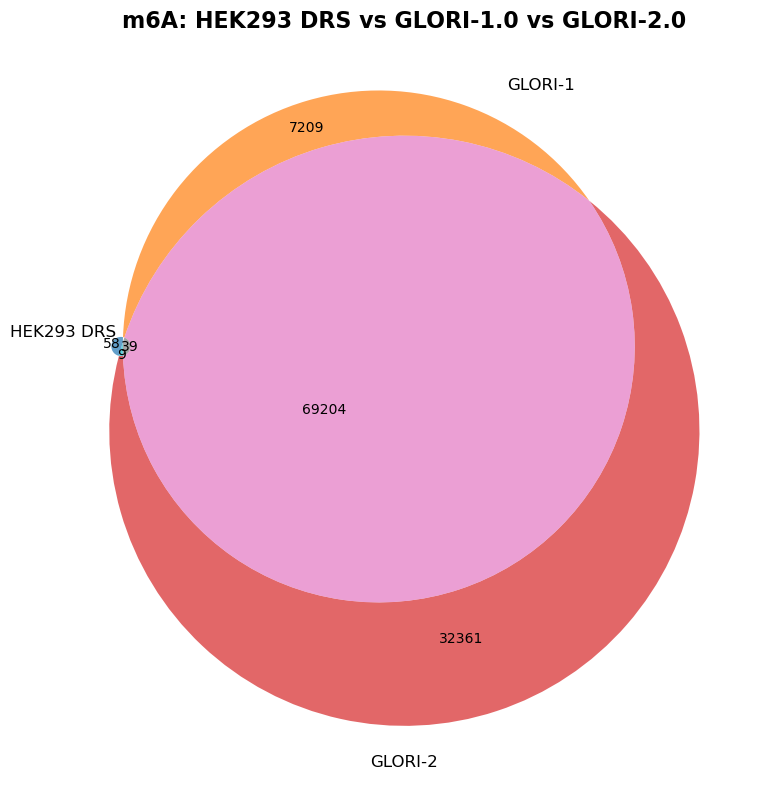

In [8]:
fig, ax = plt.subplots(figsize=(8, 8))

venn = venn3([drs_sites, glori1_sites, glori2_sites],
             set_labels=['HEK293 DRS', 'GLORI-1', 'GLORI-2'])

patch_colors = {
    '100': M6A_COLORS['DRS_HEK293'],
    '010': M6A_COLORS['GLORI1'],
    '001': M6A_COLORS['GLORI2'],
    '110': M6A_COLORS['HEK_GLORI1'],
    '101': M6A_COLORS['HEK_GLORI2'],
    '011': M6A_COLORS['GLORI1_GLORI2'],
    '111': M6A_COLORS['ALL_THREE']
}

for region_id, color in patch_colors.items():
    patch = venn.get_patch_by_id(region_id)
    if patch:
        patch.set_facecolor(color)
        patch.set_alpha(ALPHA)

ax.set_title('m6A: HEK293 DRS vs GLORI-1.0 vs GLORI-2.0', 
             fontweight='bold', fontsize=16)

plt.tight_layout()
plt.show()